<div class="alert alert-block alert-info">
<font size="5"><b><center> Section 4</font></center>
<br>
<font size="5"><b><center> Image classification Using a Convolutional Neural Retwork in PyTorch</font></center>
</div>

# Example 1: Classifying Hand-written Digits

[The MNIST Database of Handwritten Digits](http://yann.lecun.com/exdb/mnist/)

    * A training set of 60,000 examples
    * A test set of 10,000 examples
    * The digits have been size-normalized and centered in a fixed-size image

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets,transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
%matplotlib inline

## Check if a CUDA compatible devise is available

In [2]:
is_cuda=False
if torch.cuda.is_available():
    is_cuda = True

## Load, Transform, and Feed the Transformed Data into `DataLoader`

In [3]:
transformation = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST('data/section3/',train=True,transform=transformation,download=True)
test_dataset = datasets.MNIST('data/section3/',train=False,transform=transformation,download=True)

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=True)

## Examine the a batch of examples from the original data

In [4]:
sample_data = next(iter(train_loader))

In [5]:
type(sample_data)

list

In [6]:
len(sample_data)

2

In [7]:
print(sample_data[0].size())
print(sample_data[1].size())

torch.Size([32, 1, 28, 28])
torch.Size([32])


In [8]:
# The labels of the 32 images
sample_data[1]

tensor([5, 1, 1, 9, 3, 0, 3, 0, 4, 6, 2, 0, 0, 3, 4, 3, 1, 2, 4, 7, 0, 0, 9, 2,
        1, 4, 0, 7, 4, 0, 7, 7])

In [9]:
# the pixels representing in a a 28 x 28 matrix corresponding to the first image
sample_data[0][0]

tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0

In [10]:
# the label corresponding to the first image
sample_data[1][0]

tensor(5)

In [11]:
def plot_img(image):
    image = image.numpy()[0]
    mean = 0.1307
    std = 0.3081
    image = ((mean * image) + std)
    plt.imshow(image,cmap='gray')

### Visualize the Labels

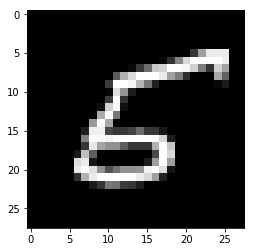

In [12]:
# Plot the first image
plot_img(sample_data[0][0])

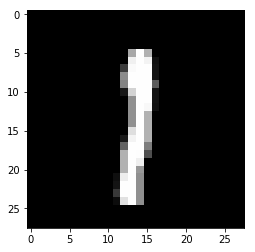

In [13]:
# Plot the second image
plot_img(sample_data[0][1])

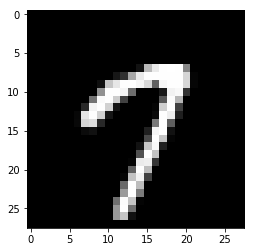

In [14]:
# Plot the 32nd image
plot_img(sample_data[0][31])

## Specify a CNN

In [15]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        #x = F.dropout(x,p=0.1, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

In [16]:
model = Net()
if is_cuda:
    model.cuda()

In [17]:
is_cuda

False

## Define an Optimization Algorithm

In [18]:
optimizer = optim.SGD(model.parameters(),lr=0.01)

In [19]:
data , target = next(iter(train_loader))

In [20]:
print(type(data))
print(type(target))

<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [21]:
print(data.shape)
print(target.shape)

torch.Size([32, 1, 28, 28])
torch.Size([32])


In [22]:
#output = model(Variable(data.cuda()))
output = model(Variable(data))

In [23]:
output.size()

torch.Size([32, 10])

In [24]:
target.size()

torch.Size([32])

## Train the model

In [25]:
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output,target)
        
        running_loss += F.nll_loss(output,target,size_average=False).data[0]
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)
    #print("Loss: %2.2f, Accuracy: %2.2f" % (loss, accuracy))
    #print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

In [26]:
#loss, acc = fit(epoch,model,train_loader, phase='training')

In [27]:
import time
start = time.time()

n_epoch = 50

train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1, n_epoch):
    epoch_loss, epoch_accuracy = fit(epoch,model,train_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,model,test_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    
end = time.time()
print("Execution Time: ", round(((end-start)/60.0),2))

/Users/jeffrey/anaconda2/envs/dl/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/Users/jeffrey/anaconda2/envs/dl/lib/python3.6/site-packages/ipykernel/__main__.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Execution Time:  23.28


In [28]:
print(round(((end-start)/60.0),2))

23.28


## Plot the training and validation loss and accuracy curves

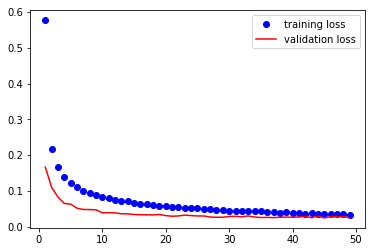

In [29]:
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()

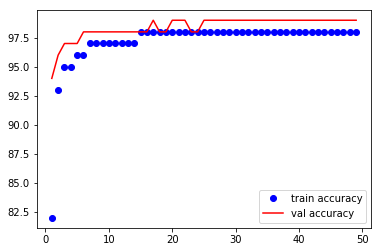

In [30]:
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()